# Imports

In [1]:
# Use the libraries for pandas, numpy and matplot
# These libraries are all executed in Python
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.signal import argrelextrema
import math
import shlex, subprocess
import os
import random

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy import signal
# Make the graphs a bit prettier, and bigger
#pd.set_option('display.mpl_style', 'default') 
#pd.set_option('display.max_columns', 60) 

# Additional plotting capabilities:
# import plotly
# plotly.offline.init_notebook_mode()

# Functions for creating the distributions

In [2]:
#Creates an estimated histogram of the distribution. 
#It is estimated due to the challenge of integrating a sum of normal distributions.
#formulas = a lambda function (created via lambda x: formula) or an array of lambda functions
#Data_points = number of records in the data so that the plot will have the correct height
#x_range_min,x_range_max,steps defines the range of the plot
#name = used to save the plot as a figure, empty means no save
def graph_int(formulas, data_points, x_range_min, x_range_max, steps, name=""):
    if not isinstance(formulas, list):
        formulas = [formulas]
    for func in formulas:
        xs = np.arange(x_range_min, x_range_max, steps)
        ys = [(func(x+steps/2)+func(x-steps/2))/2*steps for x in xs]
        total = np.sum(ys)
        y = [data_points*y/total for y in ys]
        plt.plot(xs, y)
    ax = plt.gca()
    if name != "":
        plt.savefig(name)
    plt.show()
    return ax

#Create a normal distribution from mean and std, both of which are integers.
def generate_normal(mean, std):
    mean = str(mean)
    std = str(std)
    return '(1/math.sqrt(2*math.pi*'+std+'**2))*math.exp(-(x-'+mean+')**2/(2*'+std+'**2))'

#Creates an exponential distribution form the mean as an integer.
def generate_exp(mean):
    lambdaa = str(1/mean)
    return lambdaa+'*math.exp(-x*'+lambdaa+')'

#Takes data and fits a distribution to it and outputs the parameters
#file_in = the name of a file used is in the process
#file_out = the name of the output file
#shell_script = name of the script to run, which can also include the path, however .sh is appended automatically
#setup = whether to run a setup script which is normally generated by profido
#distr = the type of distribution possibilities are:
#auto         !Warning takes a long time!
#exponential
#normal
#lognormal
#johnson
#uniform
#triangular
#erlang
#gamme
def profido_params(data, file_in="input.txt", file_out="profido_output.txt", shell_script="normal", setup=False, distr="normal"):
    data.to_csv(file_in,index=False)
    if os.name == 'nt':
        if setup:
            os.system("sh "+shell_script+"_windows_setup.sh")
        os.system("sh "+shell_script+"_windows.sh "+ distr + " " + file_in + " " + file_out)
    else:
        if setup:
            os.system("./"+shell_script+"_linux_setup.sh")
        os.system("./"+shell_script+"_linux.sh "+ distr + " " + file_in + " " + file_out)
    with open(file_out) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    mean = content[4][6:][:-7]
    std = content[5][5:][:-6]
    return mean, std

#Takes data and fits a hyper_exponential distribution to it.
#Outputs the actual distribution which can be evaluated in python.
#em_type = the of fitting, for options look in main.c of em_fit
#phase_num = the number of exponential distributions
def em_fit(data, em_type='n',phase_num=1):
    data.to_csv("input.txt", index=False)
    try:
        os.remove("input.txt.bin")
    except OSError:
        pass
    if os.name == 'nt':
        args = ["em_fit.exe", "input.txt", em_type, str(phase_num)]
    else:
        args = ["./em_fit", "input.txt", em_type, str(phase_num)]
    with open('output.txt', 'w') as f:
        subprocess.call(args, stdout=f)
    with open('output.txt') as f:
        content = f.readlines()
    content = [x.strip() for x in content] 
    content = content[(phase_num+2):(phase_num*2+2)]
    for idx, line in enumerate(content):
        line = line.replace('exp', 'math.exp')
        content[idx] = line.replace('\\', '')
    content = ''.join(content)
    return content

#Takes data and fits a hyper_exponential distribution to it.
#Outputs the parameters as an array of type [lambda, p].
#em_type = the of fitting, for options look in main.c of em_fit
#phase_num = the number of exponential distributions
def em_fit_params(data, em_type, phase_num):
    data.to_csv("input.txt", index=False)
    try:
        os.remove("input.txt.bin")
    except OSError:
        pass
    if os.name == 'nt':
        args = ["em_fit.exe", "input.txt", em_type, str(phase_num)]
    else:
        args = ["./em_fit", "input.txt", em_type, str(phase_num)]
    with open('output.txt', 'w') as f:
        subprocess.call(args, stdout=f)
    with open('output.txt') as f:
        content = f.readlines()
    content = [x.strip() for x in content] 
    result = [None]*phase_num
    for i in range(phase_num):
        line = content[i+1].split(",")
        result[i] = [line[0].replace(' ', ''),line[1].replace(' ', '')[1:]]
    return result

#Combines a list of distributions into a single distribution
#distr_list = list of distribution
#ps = list of p values which indicate the strength of a distribution as a value in [0-1]
def generate_mix_distr(distr_list, ps):
    combined_distr = ''
    for idx, distr in enumerate(distr_list):
        combined_distr += str(ps[idx])+'*'+distr +'+'
    return combined_distr[:-1]

# Algorithm to fit multiple normal distributions

In [51]:
#Retrieves the values from a histogram
#column = the name of the column of the pandas dataset (can be an integer if required)
#until = maximal value of the data to be retrieved
#bin_size = width of each bin in the histogram
def get_values(data, column,until, bin_size):
    values, _ = np.histogram(data[column][data[column] < until], bins=range(round(until/bin_size)+1))
    return values

#Find best matching value for a peak
#array = options to choose from, if empty picks best from values
#values = the values of the histogram
#mini = minimal value of interval to pick from
#maxi = maximal value of interval to pick from
def find_best_match(array,values, mini, maxi):
    if len(array) > 0:
        idx = np.argmax([values[v] for v in array])
    else:
        return np.argmax(values[mini:maxi])+mini
    return array[idx]

#This is to detect minima that were missed earlier due to many values in a row being the exact same
#values = the values of the histogram
#maxima = list of maxima
#minima = list of minima
def find_zeros(values, maxima, minima):
    gaps = []
    for i in range(len(maxima)-1):
        if len(np.where(np.logical_and(minima>maxima[i], minima<maxima[i+1]))[0]) == 0:
            if maxima[i+1]-maxima[i] > 10:
                gaps = np.append(gaps, [np.argmin(values[maxima[i]:maxima[i+1]])+maxima[i]])        
    return gaps

#Improves the boundaries of the normal distributions.
#This is usefull since profido works better if there are not a lot of outliers
#boundaries = the original boundaries, which is an array of type [int,int]
#maxima = list of maxima
#values = the values of the histogram
#margin = the maximum percentage that the values are allowed to be off from the original
def refine_boundaries(boundaries, maxima, values, margin):
    for idx, bounds in enumerate(boundaries):
        m_value = values[maxima[idx]]
        l_value = values[bounds[0]]
        r_value = values[bounds[1]]
        l_margin = (m_value-l_value)/100*margin
        r_margin = (m_value-r_value)/100*margin
        current = m_value
        i = 1
        while (current > l_margin+l_value):
            current = values[maxima[idx]-i]
            i += 1
        new_l = maxima[idx]-i
        current = m_value
        i = 1
        while (current > r_margin+r_value):
            current = values[maxima[idx]+i]
            i += 1
        new_r = maxima[idx]+i
        boundaries[idx] = [new_l,new_r]
    return boundaries

#Find estimations of the boundaries of the normal distributions within the histogram.
#max_dur = maximum value of the data to be used
#bound_margin = used for refine_boundaries as margin
#column = the name of the column of the pandas dataset (can be an integer if required)
def get_boundaries(data, max_dur, bound_margin, column):
    values, binEdges = np.histogram(data[column][data[column] < max_dur], bins=range(max_dur+2))
    yhat = signal.savgol_filter(signal.savgol_filter(values, 3, 0),3,0)
    width = 3
    maxima = np.array(argrelextrema(yhat, np.greater, order=5)[0])
    minima = np.array(argrelextrema(yhat, np.less, order=5)[0])
    minima = np.sort(np.append(minima,find_zeros(values, maxima, minima)))
    if len(minima) == 0:
        return [[0,max_dur]],[find_best_match(maxima, yhat,0,max_dur)]
    if minima[0] > maxima[0]:
        minima = np.append([0],minima)
    if minima[-1] < maxima[-1]:
        minima = np.append(minima,[max_dur])
    new_maxima = [0]*(len(minima)-1)
    for i in range(len(minima)-1):
        j = i
        while j < len(maxima) and maxima[j] < minima[i+1]:
            j += 1
        new_maxima[i] = find_best_match(maxima[i:j], yhat, int(minima[i]), int(minima[i+1]))
        maxima = np.append(new_maxima[:i+1], maxima[j:])
    bounds = [None]*len(maxima)
    for i in range(len(maxima)):
        min_distance = min(maxima[i]-minima[i],minima[i+1]-maxima[i])
        bounds[i] = [int(maxima[i]-min_distance),int(maxima[i]+min_distance)]
    bounds = refine_boundaries(bounds, maxima, values, 5)
    return bounds, maxima

#Uses profido to fit a normal distribution to the data within the limits
#data_arg = all of the data
#limits = the lower and upper bound of the interval to fit in the form of [lower,upper]
#speedUp = used to determine how many elements to skip to speed up the process (skips speedUp-1 values out of every speedUp values)
#until = maximum value of the data to be used
#column = the name of the column of the pandas dataset (can be an integer if required)
def fit_normal(data_arg, limits, speedUp, until, column):
    data = data_arg[column][data_arg[column] > limits[0]][data_arg[column] <=limits[1]][::speedUp]
    p = len(data)/len(data_arg[column][data_arg[column] <=until][::speedUp])
    mean, std = profido_params(pd.DataFrame(data=np.sort(data)), 'input.txt', 'profido_output.txt', 'normal')
    return mean, std, str(p)

#Calculates the mean and variance for the given normal distributions
#ps = array of p values
#means = means of the distributions
#l = amount of distributions
#exp = expected value of the histogram based on the distribution
def get_mean_var(ps, means, l, exp):
    mean = np.sum([ps[x]*means[x] for x in range(l)])
    var = np.sum([exp[x]*(x-mean)**2 for x in range(0,len(exp))])/np.sum(exp)
    return mean, var

#Calculates a number which indicates how good the fit is.
#This is used over goodness of fit algorithms such as chi-sqaure due to the dataset being to large that it become oversensitive.
#values = the values of the histogram
#expected = expected value of the histogram based on the distribution
#data_size = size of the dataset
def get_average_error(values, expected, data_size):
    return np.sum([math.fabs(values[x]-expected[x])**2/data_size for x in range(len(values))])

#Calculates the normal distributions for all the boundaries given
#boundaries = the boundaries, which is an array of type [int,int]
#speedUp = used to determine how many elements to skip to speed up the process (skips speedUp-1 values out of every speedUp values)
#until = maximum value of the data to be used
#column = the name of the column of the pandas dataset (can be an integer if required)
def get_normals(data, boundaries, speedUp, until, column):
    l = (len(boundaries))
    ps = [None]*l
    normal_distrs = [None]*l
    means = [None]*l
    stds = [None]*l
    for idx, limits in enumerate(boundaries):
        means[idx], stds[idx],ps[idx] = (eval(r) for r in fit_normal(data,limits, speedUp, until, column))
        normal_distrs[idx] = generate_normal(means[idx],stds[idx])
    return l,ps,means,stds,normal_distrs

#Calcualtes the estimated expected values of a histogram for the given distribution
#size = size of the dataset
#func = the lambda function which represents the distribution. Can be created by using lambda x: eval(distribution) if distribution is a string
#bin_size = the width of bins of the histogram
#until = maximum value of the histogram
def get_exp(size,func,bin_size,until):
    return [round(size*(func(x+0.5*bin_size)+func(x-0.5*bin_size))/2)*bin_size for x in np.arange(0,until,bin_size)]

#Equalizes the p values so that the sum = 1
#ps = list of p values
def eq_ps(ps):
    t = np.sum(ps)
    for p in ps:
        p = p*1/t
    return ps

#Second step to refine the normal distributions. Works by changing the mean and std of each distribution.
#size = size of the dataset
#until = maximum value of the histogram
#column = the name of the column of the pandas dataset (can be an integer if required)
#normals = the list of normal distributions
#ps = list of p values
#means = list of means of the normal distributions
#maxima = list of maxima
#stds = list of stds of the normal distributions
#bin_size = the width of bins of the histogram
#values = the values of the histogram
#init_error = initial error as defined by get_average_error()
#iterations = how many times is iterated over all of the normal distributions, recommended is 3
def refine_normals_2(data, size, until, column, normals, ps,means, maxima,stds, bin_size, values, init_error, iterations=1):
    for _ in range(iterations):
        for i in range(len(maxima)):
            mean = means[i]
            std = stds[i]
            error = 0
            while (error < init_error):
                if error > 0:
                    init_error = error
                mean -= (means[i]-maxima[i])/10
                normals[i] = generate_normal(mean,std)
                func = lambda x: eval(generate_mix_distr(normals, ps))
                expected = get_exp(size, func, bin_size, until)
                error = get_average_error(values,expected,size)
            mean += (mean-maxima[i])/10
            means[i] = mean
            error = 0
            while (error < init_error):
                if error > 0:
                    init_error = error
                std -= stds[i]/100
                normals[i] = generate_normal(mean,std)
                func = lambda x: eval(generate_mix_distr(normals, ps))
                expected = get_exp(size, func, bin_size, until)
                error = get_average_error(values,expected,size)
            std += stds[i]/100
            error = 0
            if std == stds[i]:
                while (error < init_error):
                    if error > 0:
                        init_error = error
                    std += stds[i]/100
                    normals[i] = generate_normal(mean,std)
                    func = lambda x: eval(generate_mix_distr(normals, ps))
                    expected = get_exp(size, func, bin_size, until)
                    error = get_average_error(values,expected,size)
                std -= stds[i]/100
            stds[i] = std
            normals[i] = generate_normal(mean,std)
    func = lambda x: eval(generate_mix_distr(normals, ps))
    return func, means,ps, normals, stds
    
#First step in improving the normal distributions. 
#Works by changing the boundaries and using profido to recalculate the normal distributions.
#size = size of the dataset
#boundaries = the boundaries, which is an array of type [int,int]
#speedUp = used to determine how many elements to skip to speed up the process (skips speedUp-1 values out of every speedUp values)
#until = maximum value of the histogram
#column = the name of the column of the pandas dataset (can be an integer if required)
#normals = the list of normal distributions
#ps = list of p values
#means = list of means of the normal distributions
#stds = list of stds of the normal distributions
#bin_size = the width of bins of the histogram
#values = the values of the histogram
#init_error = initial error as defined by get_average_error()
#ref = how many times is iterated over all of the normal distributions, this can take a lot of time so keep the value under 10
def refine_normals(data, size, boundaries, speedUp, until, column, normals, ps,means,stds, bin_size, values, init_error,ref):
    for i in range(len(boundaries)):
        o_limit = boundaries[i]
        best_limit = o_limit
        best_normals = normals[i]
        best_p = ps[i]
        for _ in range(ref):
            best_limit[0] += 1
            mean, std,ps[i] = (eval(r) for r in fit_normal(data,best_limit, speedUp, until, column))
            normals[i] = generate_normal(mean,std)
            func = lambda x: eval(generate_mix_distr(normals, ps))
            expected = get_exp(size, func, bin_size, until)
            error = get_average_error(values,expected,size)
            if error < init_error:
                init_error = error
                #best_limit = limits
                best_normals = normals[i]
                best_p = ps[i]
                stds[i] = std
                means[i] = mean
            else: 
                best_limit[0] -= 1
                break;
        if (best_limit == o_limit):
            for _ in range(ref):
                best_limit[0] -= 1
                mean, std,ps[i] = (eval(r) for r in fit_normal(data,best_limit, speedUp, until, column))
                normals[i] = generate_normal(mean,std)
                func = lambda x: eval(generate_mix_distr(normals, ps))
                expected = get_exp(size, func, bin_size, until)
                error = get_average_error(values,expected,size)
                if error < init_error:
                    init_error = error
                    #best_limit = limits
                    best_normals = normals[i]
                    best_p = ps[i]
                    stds[i] = std
                    means[i] = mean
                else:
                    best_limit[0] += 1
                    break;
        o_limit = boundaries[i]
        for _ in range(ref):
            best_limit[1] += 1
            mean, std,ps[i] = (eval(r) for r in fit_normal(data,best_limit, speedUp, until, column))
            normals[i] = generate_normal(mean,std)
            func = lambda x: eval(generate_mix_distr(normals, ps))
            expected = get_exp(size, func, bin_size, until)
            error = get_average_error(values,expected,size)
            if error < init_error:
                init_error = error
                #best_limit = limits
                best_normals = normals[i]
                best_p = ps[i]
                stds[i] = std
                means[i] = mean
            else:
                best_limit[1] -= 1
                break;
        if (best_limit == o_limit):
            for _ in range(ref):
                best_limit[1] -= 1
                mean, std,ps[i] = (eval(r) for r in fit_normal(data,best_limit, speedUp, until, column))
                normals[i] = generate_normal(mean,std)
                func = lambda x: eval(generate_mix_distr(normals, ps))
                expected = get_exp(size, func, bin_size, until)
                error = get_average_error(values,expected,size)
                if error < init_error:
                    init_error = error
                    #best_limit = limits
                    best_normals = normals[i]
                    best_p = ps[i]
                    stds[i] = std
                    means[i] = mean
                else:
                    best_limit[1] += 1
                    break;
        boundaries[i] = best_limit
        normals[i] = best_normals
        ps[i] = best_p
    ps = eq_ps(ps)
    func = lambda x: eval(generate_mix_distr(normals, ps))
    return func, means,ps, normals, stds

#Used to find places without peaks but with data in the histogram
#values = the values of the histogram
#expected = expected value of the histogram based on the distribution
#size = size of the dataset
#until = maximum value of the histogram
def find_gaps(values, expected, size, until):
    result = []
    start = 0
    count = 0
    for i in range(len(values)):
        if expected[i] < size/until*0.01 and values[i] > expected[i]*10:
            if count == 0:
                start = i
            count += 1
        else:
            if count > 3:
                result.append([np.sum(values[start:start+count]/size),start+count/2,count/2])
            count = 0
    return result

#The acutal function used to find the distribution, which uses all the above functions
#data = the data of which the distribution should be calculated
#until = the maximum value for which there is relatively sufficient data, to prevent getting millions of normal distributions
#column = the column which contains the data to be fitted
#refine_factor = factor used in refine_normals, recommended to keep < 10
#refine_2_iterations = how many iterations refine_normals_2 will do for every distribution, recommended is 3
#bin_size = width of the bins in the histogram (this is not tested very well so recommended to keep at 1)
#bound_margin = is a margin used for refining the bounds
#fast = whether the speedUp factor should be used
#speedUp = used to determine how many elements to skip to speed up the process (skips speedUp-1 values out of every speedUp values)
#plot_name = saves the plot as a file, if empty does not save the plot
def find_distr(data, until, column='duration_processing', refine_factor=3, refine_2_iterations=1, bin_size=1, bound_margin=3,\
               fast=True, speedUp=1000, plot_name=""):
    if not fast:
        speedUp = 1
    boundaries, maxima = get_boundaries(data,until,bound_margin, column)
    size = len(data[column][data[column] < until])
    l,ps,means,stds,normals = get_normals(data, boundaries, speedUp, until, column)
    ps = eq_ps(ps)
    func = lambda x: eval(generate_mix_distr(normals, ps))
    values = get_values(data,column,until, bin_size)
    expected = get_exp(size, func, bin_size, until)
    gaps = find_gaps(values,expected,size,until)
    for gap in gaps:
        ps.append(gap[0])
        means.append(gap[1])
        stds.append(gap[2])
        normals.append(generate_normal(gap[1],gap[2]))
        maxima = np.append(maxima,[gap[1]])
    ps = eq_ps(ps)
    func = lambda x: eval(generate_mix_distr(normals, ps))
    values = get_values(data,column,until, bin_size)
    expected = get_exp(size, func, bin_size, until)
    average_error = get_average_error(values,expected,size)
    
    print("before:")
    print(np.corrcoef(values, expected))
    mean, var = get_mean_var(ps,means,l, expected) 
    print(np.mean(data[column][data[column] < until]),mean)
    print(np.var(data[column][data[column] < until]),var)
    print(average_error)
    
    func, means, ps, normals, stds = refine_normals(data, size, boundaries, speedUp, until, column, normals, ps, means, stds, bin_size, values, average_error,refine_factor)
    func, means, ps, normals, stds = refine_normals_2(data, size, until, column, normals, ps,means, maxima,stds, bin_size, values, average_error, refine_2_iterations)
    ps = eq_ps(ps)
    expected = get_exp(size, func, bin_size, until)
    average_error = get_average_error(values,expected,size)
    
    print("after:")
    print(np.corrcoef(values, expected))
    mean, var = get_mean_var(ps,means,l, expected) 
    print(np.mean(data[column][data[column] < until]),mean)
    print(np.var(data[column][data[column] < until]),var)
    print(average_error)
    plt.figure(figsize=(20,5))
    plt.hist(data[column][data[column] < until], bins=range(round(until/bin_size)+1))
    ax =graph_int(func,size,0,until,bin_size)
    for i in range(len(normals)):
        print(ps[i],stds[i],means[i])
    return generate_mix_distr(normals,ps)

# Creating the inter_arrival and service_time

data_IA.to_csv("extended_data_1.csv.gz", 
        compression='gzip')

# 1. Loading and representing the data

In [4]:
#Imports the data from the extended dataset which includes service -,inter_arrival - and completion times
#Format is slightly different then the non extended dataset due to exporting, therefor this is the way to import
location = 'extended_data_1.csv.gz'
data_IA = pd.read_csv(location, 
        compression='gzip', index_col=0)

In [5]:
data_IA

,datetime,dataset_id,cluster_host,request_method,response_size,status_code,duration,duration_processing,completion_time,service_time,inter_arrival
1,2016-08-10 00:00:08.174,17,jaws09.data.be.nl,GET,135701.0,200,115,114,2016-08-10 00:00:08.289,114,0.418
2,2016-08-10 00:00:08.450,17,jaws08.data.be.nl,GET,135701.0,200,121,120,2016-08-10 00:00:08.571,120,0.276
4,2016-08-10 00:00:08.728,18,jaws07.data.be.nl,GET,33853.0,200,78,78,2016-08-10 00:00:08.806,78,0.278
6,2016-08-10 00:00:09.646,1,jaws07.data.be.nl,GET,284529.0,200,90,89,2016-08-10 00:00:09.736,89,0.918
7,2016-08-10 00:00:13.524,22,jaws09.data.be.nl,GET,77987.0,200,75,75,2016-08-10 00:00:13.599,75,3.878
8,2016-08-10 00:00:15.293,22,jaws08.data.be.nl,GET,77987.0,200,80,80,2016-08-10 00:00:15.373,80,1.769
10,2016-08-10 00:00:16.242,18,jaws08.data.be.nl,GET,33853.0,200,80,79,2016-08-10 00:00:16.322,79,0.949
11,2016-08-10 00:00:16.434,17,jaws03.data.be.nl,GET,135701.0,200,118,117,2016-08-10 00:00:16.552,117,0.192
12,2016-08-10 00:00:16.563,17,jaws01.data.be.nl,GET,135701.0,200,118,118,2016-08-10 00:00:16.681,118,0.129
14,2016-08-10 00:00:16.669,1,jaws09.data.be.nl,GET,284529.0,200,82,81,2016-08-10 00:00:16.751,81,0.106


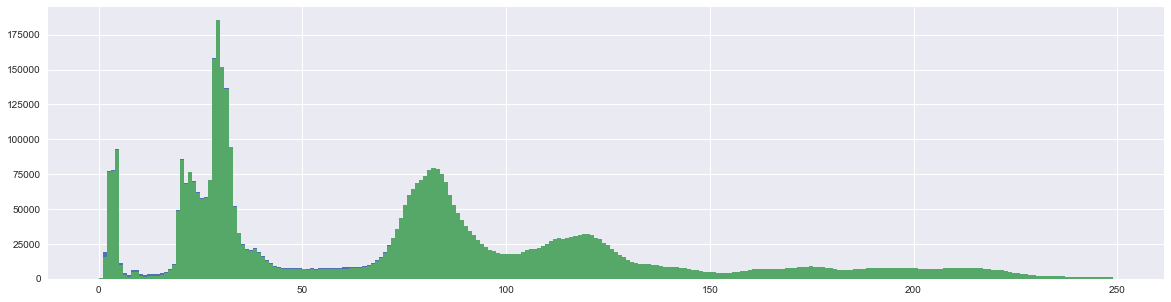

In [6]:
#Used to show the similarities between the service_time and duration_processing
data_IA['service_time'][data_IA['service_time']< 250].hist(bins=250, figsize=(20,5))
data_IA['duration_processing'][data_IA['duration_processing']< 250].hist(bins=250, figsize=(20,5))

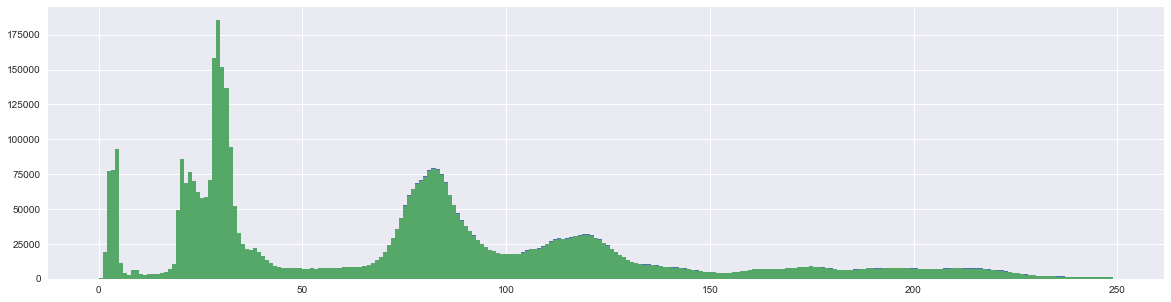

In [7]:
#Used to show the similarities between the service_time and duration_processing
data_IA['duration_processing'][data_IA['duration_processing']< 250].hist(bins=250, figsize=(20,5))
data_IA['service_time'][data_IA['service_time']< 250].hist(bins=250, figsize=(20,5))

In [8]:
print('mean service_time, mean duration_processing:',data_IA['service_time'][data_IA['service_time'] >0].mean(),\
      data_IA['duration_processing'][data_IA['duration_processing'] >0].mean())

mean service_time, mean duration_processing: 94.83312196730945 97.1816883140892


# Fitting the inter_arrival time

In [9]:
#Fitting the exponential part of the inter_arrival time
plt.figure(figsize=(20,5))
steps = 0.001
max_x = 5
data = data_IA['inter_arrival'][data_IA['inter_arrival'].between(1.2,1.4) == False]
fit = em_fit_params(data,'n',1)
exp_distr = '+'.join([exp[1]+'*('+generate_exp(1/eval(exp[0]))+')' for exp in fit])
p_exp = len(data)/len(data_IA['inter_arrival'][data_IA['inter_arrival'] < max_x])
#Print Parameters
for exp in fit:
    print('lambda, p:',exp[0],exp[1])
print('formula:',exp_distr)
print('percentage of total data:',p_exp)

lambda, p: 5.302162e+000 1.000000e+000
formula: 1.000000e+000*(5.302162*math.exp(-x*5.302162))
percentage of total data: 0.8424101721787897


In [10]:
#Fitting the normal part of the inter_arrival time
plt.figure(figsize=(20,5))
data = data_IA['inter_arrival'][data_IA['inter_arrival'] >= 1.1][data_IA['inter_arrival'] < 1.5]
mean, std = profido_params(pd.DataFrame(data=np.sort(data)), 'some_input.txt', 'some_profido_output.txt', 'normal')
normal_distr = generate_normal(mean,std)
p_normal = len(data)/len(data_IA['inter_arrival'][data_IA['inter_arrival'] < max_x])
print('mean,std:',mean,std)
print('percentage of total data:',p_normal)

mean,std: 1.26 0.0374876
percentage of total data: 0.16648186199032008


Mix_distribution: (0.8424101721787897*(1.000000e+000*(5.302162*math.exp(-x*5.302162)))+0.16648186199032008*((1/math.sqrt(2*math.pi*0.0374876**2))*math.exp(-(x-1.26)**2/(2*0.0374876**2))))


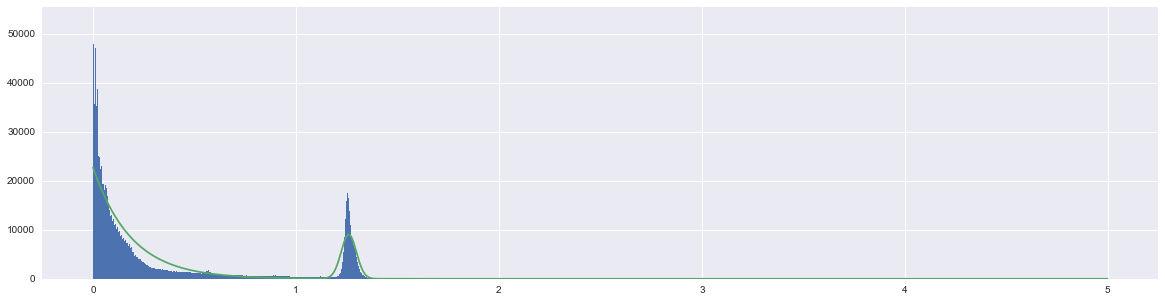

In [11]:
#Combining both parts of the inter_arrival time and plotting
plt.figure(figsize=(20,5))
data = data_IA['inter_arrival'][data_IA['inter_arrival'] < max_x]
y, x, _ = plt.hist(data,bins=round(max_x/steps))
print('Mix_distribution:','('+str(p_exp)+'*'+'('+exp_distr + ')+'+str(p_normal)+'*'+'('+ normal_distr +'))')
mix_distr = lambda x: eval('('+str(p_exp)+'*'+'('+exp_distr + ')+'+str(p_normal)+'*'+'('+ normal_distr +'))')
graph_int(mix_distr,len(data_IA['inter_arrival'][data_IA['inter_arrival'] < max_x]),0,max_x,steps)

# Fitting the service_time

[  3  29  82 119 175 196 211]
[ 12  25  52 101 153 184 205]
[[0, 6], [19, 25], [25, 33], [63, 101], [101, 137], [166, 184], [187, 205], [205, 217]]
[[-1, 7], [18, 26], [25, 34], [66, 97], [102, 135], [167, 184], [186, 205], [206, 217]]
before:
[[ 1.          0.97813913]
 [ 0.97813913  1.        ]]
77.89421051444916 61.6790393359
3049.7301796746165 2638.64114369
1869.90494552
after:
[[ 1.         0.9833409]
 [ 0.9833409  1.       ]]
77.89421051444916 69.6344701668
3049.7301796746165 3073.1312493
1324.24326682


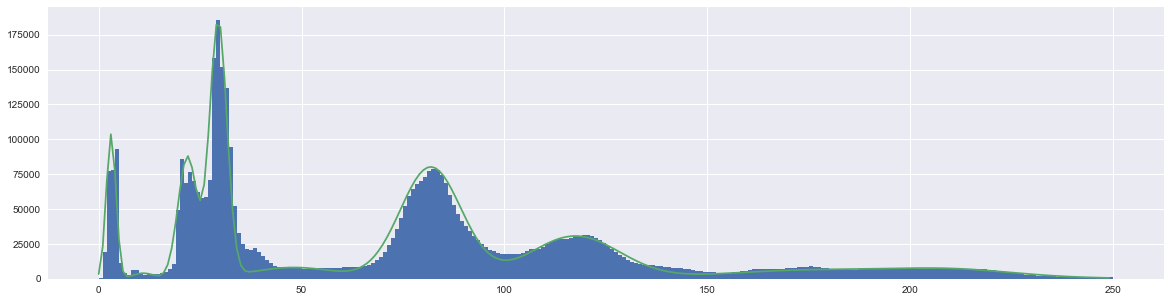

0.05775810022137251 1.0662597 3.06513293754
0.09478768363855906 2.2632479999999995 21.8684274556
0.18313543972630308 2.0639025 29.4654524303
0.28315556449989937 7.5478491 81.8160313096
0.15797947273093177 11.060992999999993 117.391244258
0.03723083115314953 19.436029999999988 172.673222998
0.037029583417186554 29.99573500000007 193.099776289
0.031797142282149325 14.94896399999999 210.62158339
0.00499165775539 2.6100000000000025 11.0
0.0399928495046 10.499999999999998 48.0


In [39]:
#Calculate the distribution for the service_time
distribution = find_distr(data_IA,250, refine_factor=6, refine_2_iterations=3, column='service_time', bin_size=1)

In [44]:
#Print the distribution as a string
distribution

'0.05775810022137251*(1/math.sqrt(2*math.pi*1.0662597**2))*math.exp(-(x-3.06513293754)**2/(2*1.0662597**2))+0.09478768363855906*(1/math.sqrt(2*math.pi*2.2632479999999995**2))*math.exp(-(x-21.8684274556)**2/(2*2.2632479999999995**2))+0.18313543972630308*(1/math.sqrt(2*math.pi*2.0639025**2))*math.exp(-(x-29.4654524303)**2/(2*2.0639025**2))+0.28315556449989937*(1/math.sqrt(2*math.pi*7.5478491**2))*math.exp(-(x-81.8160313096)**2/(2*7.5478491**2))+0.15797947273093177*(1/math.sqrt(2*math.pi*11.060992999999993**2))*math.exp(-(x-117.391244258)**2/(2*11.060992999999993**2))+0.03723083115314953*(1/math.sqrt(2*math.pi*19.436029999999988**2))*math.exp(-(x-172.673222998)**2/(2*19.436029999999988**2))+0.037029583417186554*(1/math.sqrt(2*math.pi*29.99573500000007**2))*math.exp(-(x-193.099776289)**2/(2*29.99573500000007**2))+0.031797142282149325*(1/math.sqrt(2*math.pi*14.94896399999999**2))*math.exp(-(x-210.62158339)**2/(2*14.94896399999999**2))+0.00499165775539*(1/math.sqrt(2*math.pi*2.61000000000000

# Randomly generated testing

In [49]:
#Generate a random dataset consisting of several normal distributions
num_distr = int(round(random.random()*5+5))
length_data = int(round(random.random()*500000+num_distr*10000))
ps = [0]*num_distr
for i in range(num_distr):
    ps[i] = random.random()
ps = eq_ps(ps)
s = []
for p in ps:
    s = np.append(s, np.random.normal(random.random()*350, random.random()*3+3, int(p*length_data)))

[ 52  85 111 153 218]
[ 65  98 137]
[[39, 65], [72, 98], [98, 124], [137, 169], [169, 267]]
[[41, 62], [72, 98], [99, 124], [143, 163], [206, 231]]
before:
[[ 1.          0.89804518]
 [ 0.89804518  1.        ]]
151.4834935382794 149.495867368
3774.6004382709316 3831.92016208
6424.50877493
after:
[[ 1.          0.99930999]
 [ 0.99930999  1.        ]]
151.4834935382794 149.256227327
3774.6004382709316 3788.39374149
39.3034425746


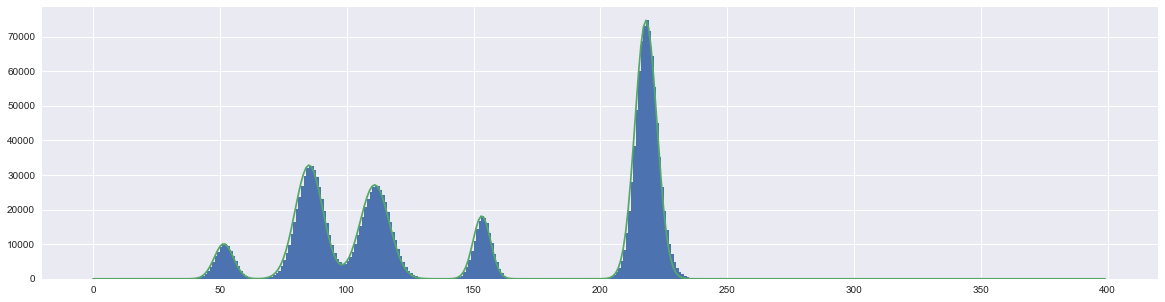

0.05 3.748963399999992 51.5611661056
0.2336842105263158 5.428001119999994 85.144790173
0.2026315789473684 5.697000299999997 111.032990166
0.08157894736842106 3.4029161099999965 153.268018146
0.42105263157894735 4.2905575680000005 217.974987848


In [50]:
#Fit the randomly generated dataset
test_distribution = find_distr(pd.DataFrame(data=np.sort([s]).T), 400, refine_factor=0, refine_2_iterations=3, column=0, bin_size=1, speedUp=1000)